# Prevendo o atrito de clientes 

## 1. Entendimento do Problema

No negócio de cartões de crédito em bancos de varejo, o atrito de um cliente é definido como a declaração voluntária de cancelamento do serviço por parte do cliente. O atrito de cartão de crédito geralmente tem um impacto negativo nos resultados do negócio de cartões, com perda de vendas e receita junto com a depreciação de ativos. Pode haver muitos fatores que ocasionam no cancelamento da conta, como insatisfação com o serviço ao cliente, proposta de valor do cartão que não atende às expectativas do cliente, melhores ofertas competitivas, etc. Ao analisar os mais significativos desses fatores, é possível para uma empresa compreender a probabilidade de atrito de cada conta. Isto possibilita a construção de estratégias de modo a combater proativamente a perda de clientes.

Nesse sentido, imagine o seguinte caso para esse projeto:

>O gerente do negócios de cartões de crédito de um banco está enfrentando graves problemas de atrito de clientes nos últimos meses. Como isso está impactando os negócios, o gerente lhe encarrega de analisar os dados para entender os  clientes que atritam e criar uma solução que permita identificar clientes que cancelarão suas contas em um futuro próximo, para que assim ele possa concentrar seus esforços em prevenir o atrito desses clientes

## 2. Pré-processamento e Manipulação dos Dados

Vamos começar importando as bibliotecas que iremos utilizar ao longo do projeto e definindo alguns padrões para a visualização dos gráficos.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

sns.set_style('darkgrid')
sns.set_palette('Set1')
matplotlib.rcParams['font.size'] = 14
pd.set_option('display.max_columns', None)

Vamos agora importar o conjunto de dados usando o Pandas, descartando as últimas duas colunas por não serem necessárias:

In [2]:
churners_df = pd.read_csv('./data/BankChurners.csv')
churners_df.drop(churners_df.columns[-2:], axis=1, inplace=True)

In [3]:
churners_df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
churners_df.shape

(10127, 21)

Como pode ser visto, no dataset possuímos 10127 observações e 21 colunas. Ter um entendimento do que diz respeito cada coluna é importante, por isso, devemos nos atentar à definição das variáveis:

- **CLIENTNUM:** Identificador único do cliente.
- **Attrition_Flag:** Indica a situação do cliente nos próximos 6 meses.
- **Customer_Age:** Idade do cliente.
- **Gender:** Sexo do cliente.
- **Dependent_count:** Número de dependentes do cliente.
- **Education_Level:** Grau de escolaridade do cliente.
- **Marital_Status:** Estado civil do cliente.
- **Income_Category:** Categoria de renda anual do cliente em dólares.
- **Card_Category:** Tipo de cartão.
- **Months_on_book:** Total de meses como cliente.
- **Total_Relationship_Count:** Número de produtos mantidos pelo cliente.
- **Months_Inactive_12_mon:** Número de meses inativos nos últimos 12 meses.
- **Contacts_Count_12_mon:** Número de contatos nos últimos 12 meses.
- **Credit_Limit:** Limite de crédito do cartão.
- **Total_Revolving_Bal:** Crédito rotativo total.
- **Avg_Open_To_Buy:** Média do crédito disponível nos últimos 12 meses.
- **Total_Amt_Chng_Q4_Q1:** Variação no montante das transações (Comparando o quarto trimestre com o primeiro).
- **Total_Trans_Amt:** Montante total das transações nos últimos 12 meses.
- **Total_Trans_Ct:** Total de transações nos últimos 12 meses.
- **Total_Ct_Chng_Q4_Q1:** Variação no total de transações (Comparando o quarto trimestre com o primeiro).
- **Avg_Utilization_Ratio:** Taxa média de utilização do cartão.

As colunas podem apresentar tipos de dados incorretos, por exemplo, uma variável numérica como a idade pode estar representada como uma string, por isso é importante checarmos os tipos de cada coluna:

In [5]:
churners_df.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

Outro fator que é importante nos atentarmos é a ausência de valores no conjunto de dados, ou seja, quando nenhuma informação foi registrada em determinada observação de uma variável. Uma forma simples de identificarmos e visualizarmos os valores faltantes no dataset é utilizando a biblioteca missingno:

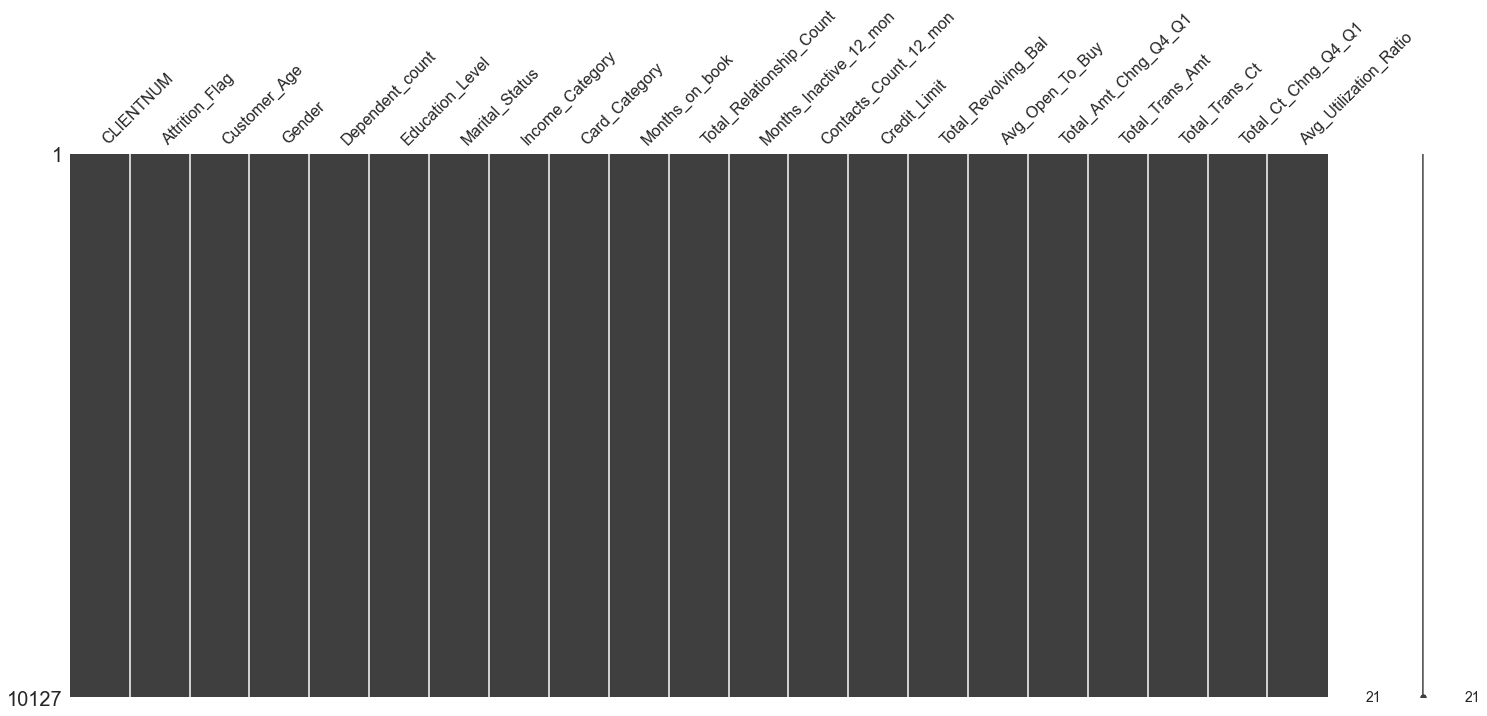

In [6]:
msno.matrix(churners_df);

Entretanto, um cuidado que devemos ter quando analisarmos os valores faltantes é que eles também podem aparecer como valores propriamente ditos do conjunto de dados, mas que não possuem nenhum significado específico. No nosso dataset, podemos notar que em que algumas colunas, como "Education_Level", temos a categoria "Unknown":

In [7]:
churners_df.Education_Level.unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

Há diversas formas de lidarmos com valores faltantes, como excluir as linhas em que há ausência de dados, substituir os valores faltantes pela média, moda ou mediana ou substituí-los por uma nova categoria. No nosso caso, iremos manter os valores faltantes como uma categoria à parte.

Por fim, podemos obter alguns insights preliminares sobre os dados utilizando o método *.describe()* do Pandas, que retorna um relatório estatístico das variáveis númericas:

In [8]:
churners_df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


A princípio não aparentam existir nenhum problema com as colunas, então podemos seguir para a etapa de análise exploratória dos dados.

## 3. Análise Exploratória dos Dados

A etapa de Análise Exploratória dos Dados é onde buscamos analisar o conjunto de dados e responder determinadas questões, nos utilizando principalmente da visualização de dados. É uma etapa de extrema importância para termos uma maior compreensão dos dados, detectarmos irregularidades e entendermos como as variáveis se relacionam. Sendo assim, vamos começar a explorar o nosso dataset:

### Como a variável alvo está distribuída?

Algo que pode acontecer quando estamos lidando com problemas de classificação é haver um desbalanceamento nos dados, sendo assim, vamos começar checando como as classes estão distribuídas no nosso target.

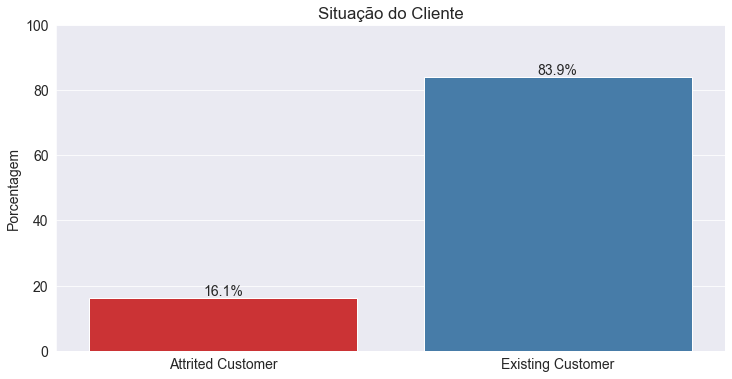

In [9]:
situation_counts = churners_df.Attrition_Flag.value_counts(normalize=True, ascending=True)*100

plt.figure(figsize=(12, 6))
ax = sns.barplot(x = situation_counts.index, y = situation_counts)
plt.title('Situação do Cliente')
plt.ylabel('Porcentagem')
plt.ylim(0, 100)

for container in ax.containers: # Displaying values at bars
    ax.bar_label(container, fmt='%.1f%%');

Pode-se notar que os clientes existentes representam 83.9% do dataset, enquanto os clientes atritados correspodem a apenas 16.1% do mesmo. Vale ressaltar que esse desbalanceamento precisará ser tratado futuramente, caso contrário, acarretará em problemas na construção e desempenho do modelo.

### Qual a distribuição do sexo dos clientes?

Verificando a proporção do sexo dos clientes, percebe-se que as mulheres são a maioria do conjunto de dados.

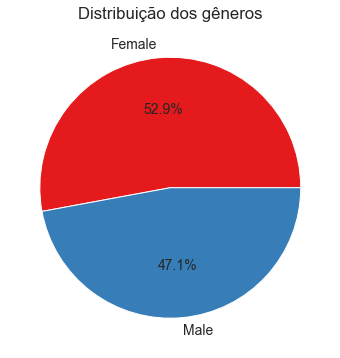

In [10]:
gender_counts = churners_df.Gender.map({'M': 'Male', 'F': 'Female'}).value_counts()

plt.figure(figsize=(12, 6))
plt.title('Distribuição dos gêneros')
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%');

### Qual é o grau de escolaridade dos clientes?

O modo com que os clientes utilizam o cartão de crédito pode variar dependendo do seu grau de escolaridade. Vamos então comparar os gruas de escolaridades dos clientes:

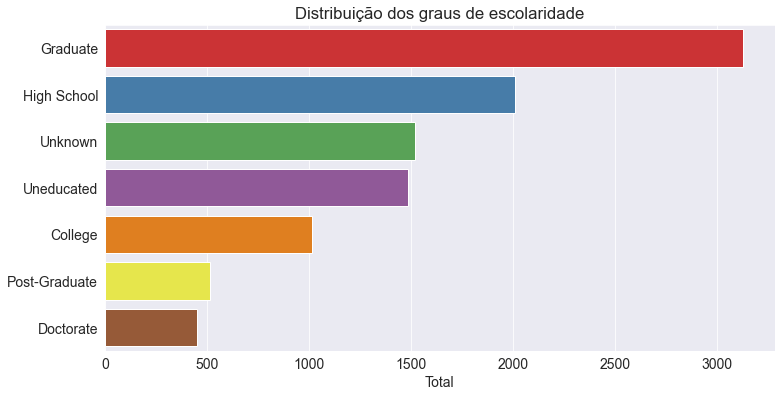

In [11]:
education_counts = churners_df.Education_Level.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x = education_counts, y = education_counts.index)
plt.title('Distribuição dos graus de escolaridade')
plt.xlabel('Total');

Considerando que todos os que constam como desconhecido não possuem educação, temos então que 70% dos clientes possuem algum grau de instrução.

### Qual a renda anual dos clientes?

Vamos analisar como estão divididas as rendas anuais no conjunto de dados:

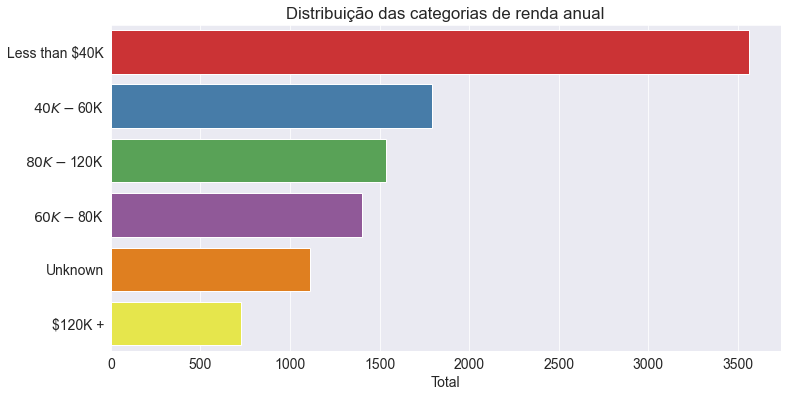

In [12]:
income_counts = churners_df.Income_Category.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x = income_counts, y = income_counts.index)
plt.title('Distribuição das categorias de renda anual')
plt.xlabel('Total');

Podemos observar que aproximadamente 30% dos clientes do conjunto de dados possuem renda inferior a 40000 dólares por ano e que menos de 10% dos clientes possuem uma renda anual de mais de 120000 doláres.

### Qual a distribuição dos tipos de cartões?

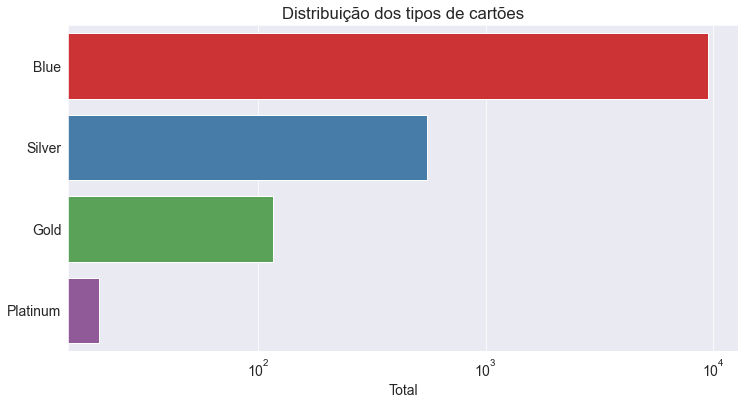

In [13]:
card_counts = churners_df.Card_Category.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x = card_counts, y = card_counts.index)
plt.title('Distribuição dos tipos de cartões')
plt.xlabel('Total')
plt.xscale('log');

Mais de 90% dos clientes no conjunto de dados possuem cartão Blue e menos de 1% possuem cartão Platinum.

### Como a idade está distribuída em cada classe?

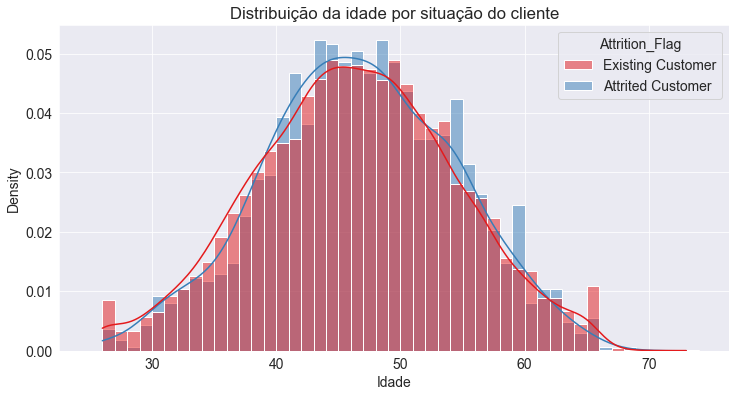

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(x = churners_df.Customer_Age, hue = churners_df.Attrition_Flag, bins=np.arange(25, 75), stat='density', common_norm = False, kde=True)
plt.title('Distribuição da idade por situação do cliente')
plt.xlabel('Idade');

Podemos observar que as distribuições das idades seguem uma distribuição semelhante à normal e não há muita diferença entre a distribuição dos clientes existentes e atritados.

### Como o limite de crédito está distribuída em cada classe?

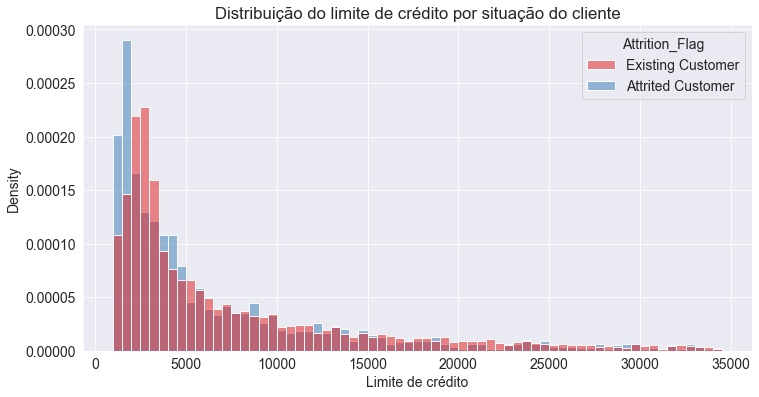

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(x = churners_df.Credit_Limit, hue = churners_df.Attrition_Flag, bins=np.arange(1000, 35000, 500), stat='density', common_norm = False)
plt.title('Distribuição do limite de crédito por situação do cliente')
plt.xlabel('Limite de crédito');

Como é de se esperar, a quantidade de clientes diminui à medida que o limite de crédito aumenta.

### Qual a relação do crédito rotativo com a situação do cliente?

O crédito rotativo é um tipo de crédito oferecido ao consumidor quando não é realizado o pagamento total da fatura do cartão antes do vencimento. Vamos analisar se o grau de utilização do crédito rotativo possui alguma relação com a situação do cliente.

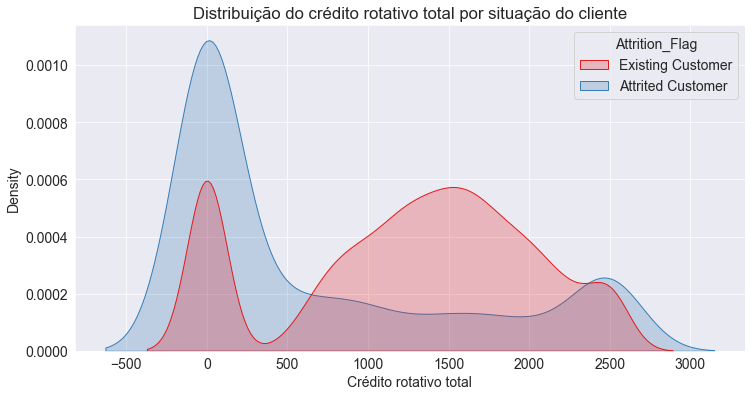

In [16]:
plt.figure(figsize=(12, 6))
sns.kdeplot(x = churners_df.Total_Revolving_Bal, hue = churners_df.Attrition_Flag, shade= True, common_norm = False)
plt.title('Distribuição do crédito rotativo total por situação do cliente')
plt.xlabel('Crédito rotativo total');

Pelas distribuições, podemos notar que clientes que utilizam menos o crédito rotativo, ou seja, possuem pouca ou nenhuma dívida, são mais propensos a atrito.

### Clientes que utilizam menos o cartão são mais propensos a atrito?

É de se supor que clientes que utilizem menos o cartão possuem mais chance de atrito, para confirmar isso, vamos verificar como estão distribuídos o total de transações, o montante total das transações e a taxa média de utilização dependendo do estado do cliente:

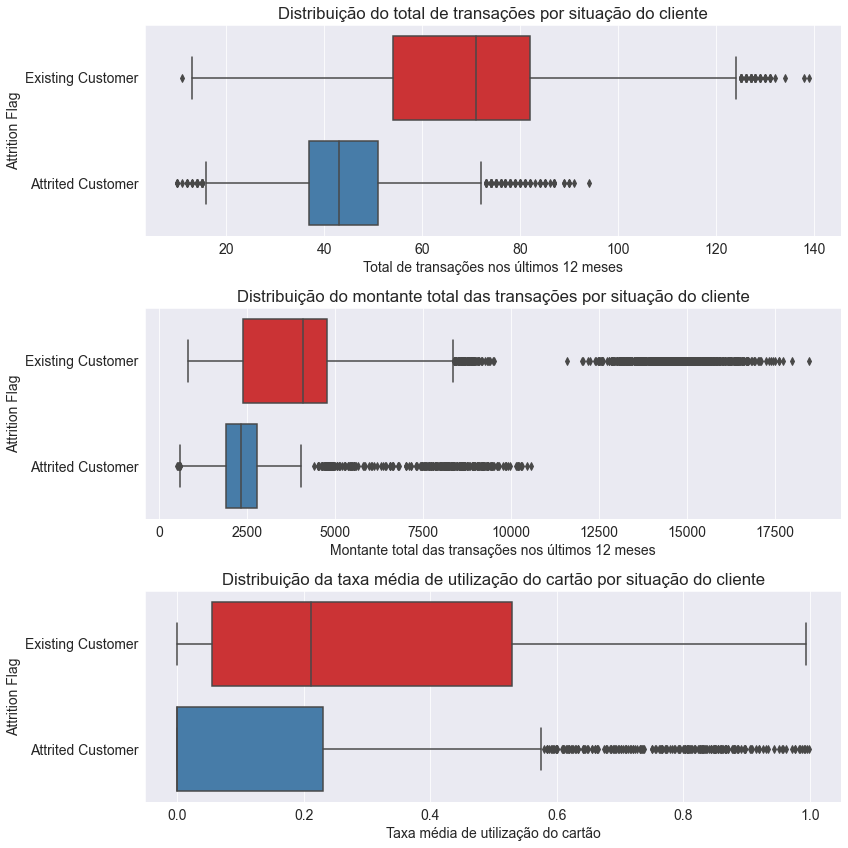

In [17]:
fig, ax = plt.subplots(3, figsize=(12, 12))

sns.boxplot(x = churners_df.Total_Trans_Ct, y = churners_df.Attrition_Flag, ax=ax[0])
ax[0].set_title('Distribuição do total de transações por situação do cliente')
ax[0].set_xlabel('Total de transações nos últimos 12 meses')
ax[0].set_ylabel('Attrition Flag');

sns.boxplot(x = churners_df.Total_Trans_Amt, y = churners_df.Attrition_Flag, ax=ax[1])
ax[1].set_title('Distribuição do montante total das transações por situação do cliente')
ax[1].set_xlabel('Montante total das transações nos últimos 12 meses')
ax[1].set_ylabel('Attrition Flag')

sns.boxplot(x = churners_df.Avg_Utilization_Ratio, y = churners_df.Attrition_Flag, ax=ax[2])
ax[2].set_title('Distribuição da taxa média de utilização do cartão por situação do cliente')
ax[2].set_xlabel('Taxa média de utilização do cartão')
ax[2].set_ylabel('Attrition Flag')

fig.tight_layout();

Analisando os três boxplots, é possível notar que, de fato, os clientes atritados apresentam menor grau de atividade que os clientes existentes. Desse modo, se atentar aos clientes que passam a utilizar com menos frequência o cartão pode ajudar a reduzir o número de atritos.

### Qual a proporção do estado dos clientes dependendo de certa categoria?

Vamos agora analisar se a distribuição da variável alvo é afetada dependendo da categoria que o cliente possui. Para isso, iremos comparar a proporção do estado do cliente dependendo do tipo de cartão, do grau de escolaridade ou da categoria de renda anual.

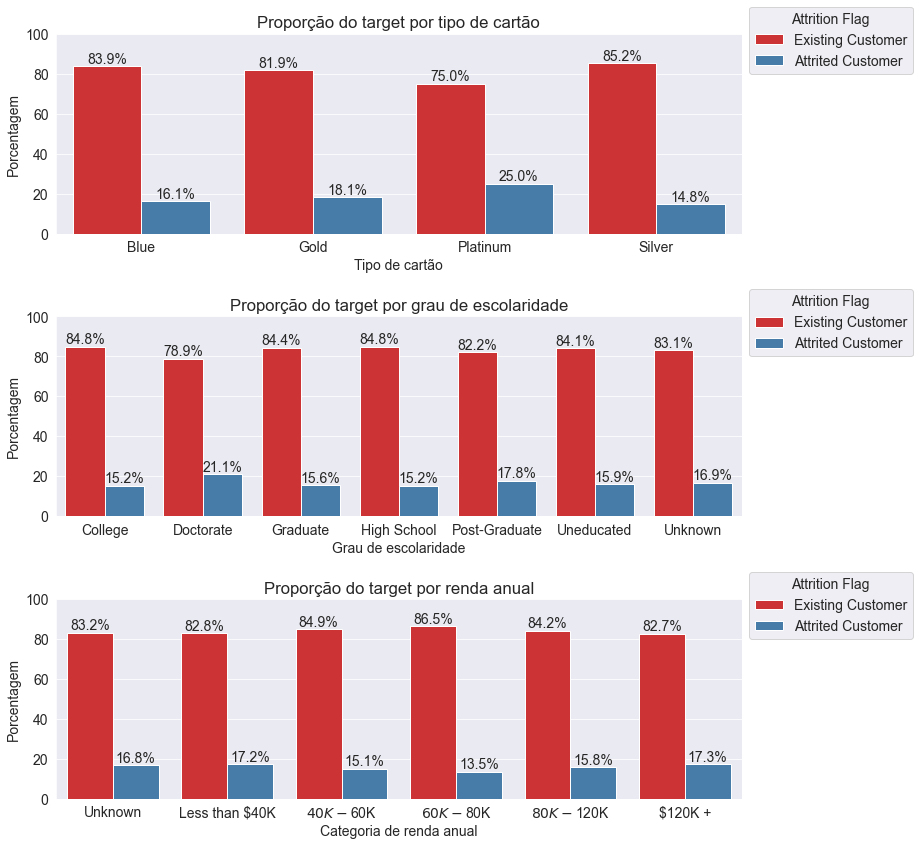

In [18]:
fig, ax = plt.subplots(3, figsize=(13, 12))

attrition_by_card = (churners_df.groupby('Card_Category')['Attrition_Flag'].value_counts(normalize=True)*100).rename('Percentage').reset_index()
sns.barplot(data=attrition_by_card, x='Card_Category', y='Percentage', hue='Attrition_Flag', ax=ax[0])
ax[0].set_title('Proporção do target por tipo de cartão')
ax[0].set_xlabel('Tipo de cartão')
ax[0].set_ylabel('Porcentagem')
ax[0].set_ylim(0, 100)
ax[0].legend(title = 'Attrition Flag', loc=(1.01, 0.8))
for container in ax[0].containers: # Displaying values at bars
    ax[0].bar_label(container, fmt='%.1f%%');

    
attrition_by_education = (churners_df.groupby('Education_Level')['Attrition_Flag'].value_counts(normalize=True)*100).rename('Percentage').reset_index()
sns.barplot(data=attrition_by_education, x='Education_Level', y='Percentage', hue='Attrition_Flag', ax=ax[1])
ax[1].set_title('Proporção do target por grau de escolaridade')
ax[1].set_xlabel('Grau de escolaridade')
ax[1].set_ylabel('Porcentagem')
ax[1].set_ylim(0, 100)
ax[1].legend(title = 'Attrition Flag', loc=(1.01, 0.8))
for container in ax[1].containers: # Displaying values at bars
    ax[1].bar_label(container, fmt='%.1f%%');
    

attrition_by_income = (churners_df.groupby('Income_Category')['Attrition_Flag'].value_counts(normalize=True)*100).rename('Percentage').reset_index()
sns.barplot(data=attrition_by_income, x='Income_Category', y='Percentage', hue='Attrition_Flag', ax=ax[2],
            order=['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'])
ax[2].set_title('Proporção do target por renda anual')
ax[2].set_xlabel('Categoria de renda anual')
ax[2].set_ylabel('Porcentagem')
ax[2].set_ylim(0, 100)
ax[2].legend(title = 'Attrition Flag', loc=(1.01, 0.8))
for container in ax[2].containers: # Displaying values at bars
    ax[2].bar_label(container, fmt='%.1f%%');

fig.tight_layout();

Em geral, há bem pouca variação na proporção entre as categorias, mas podemos destacar que clientes com cartão Platinum possuem uma maior taxa de atrito em relação à clientes com outros tipos de cartão e que clientes com doutorado também possuem um maior nível de atrito em comparação com outros graus de escolaridade.

### Quais tipos de clientes possuem mais chance de atrito?

Por fim, vamos buscar analisar quais os grupos de clientes (considerando sexo, grau de escolaridade, renda anual e tipo de cartão) possuem uma maior taxa de atrito. Para isso, vamos começar filtrando a quantidade de clientes em cada classe da variável alvo pelo tipo de cliente.

In [19]:
types_df = pd.crosstab([churners_df['Gender'], churners_df['Education_Level'], churners_df['Income_Category'], churners_df['Card_Category']], churners_df.Attrition_Flag)
types_df.head(10)

Attrition_Flag                                        Attrited Customer  \
Gender Education_Level Income_Category Card_Category                      
F      College         $40K - $60K     Blue                          15   
                                       Gold                           0   
                                       Silver                         0   
                       Less than $40K  Blue                          46   
                                       Gold                           0   
                                       Silver                         2   
                       Unknown         Blue                          15   
                                       Gold                           0   
                                       Silver                         1   
       Doctorate       $40K - $60K     Blue                           7   

Attrition_Flag                                        Existing Customer  
Gender Education_Level Income_Category Card_Category                     
F      College         $40K - $60K     Blue                          87  
                                       Gold                           2  
                                       Silver                         4  
                       Less than $40K  Blue                         261  
                                       Gold                           1  
                                       Silver                         9  
                       Unknown         Blue                          85  
                                       Gold                           1  
                                       Silver                         3  
       Doctorate       $40K - $60K     Blue                          32

Para evitar irregularidades, vamos considerar apenas grupos de clientes que possuem mais de 150 observações no nosso conjunto de dados.

In [20]:
types_df = types_df[types_df.sum(axis=1) > 150]

Vamos agora dividir o número de clientes atritados de cada grupo pelo total de clientes desse grupo para conseguir a porcentagem de atrito dos grupos de clientes.

In [21]:
top_percentage = (types_df['Attrited Customer'] * 100 / types_df.sum(axis=1)).sort_values(ascending=False).head(15)

In [22]:
top_types = [str(i) for i in top_percentage.index]

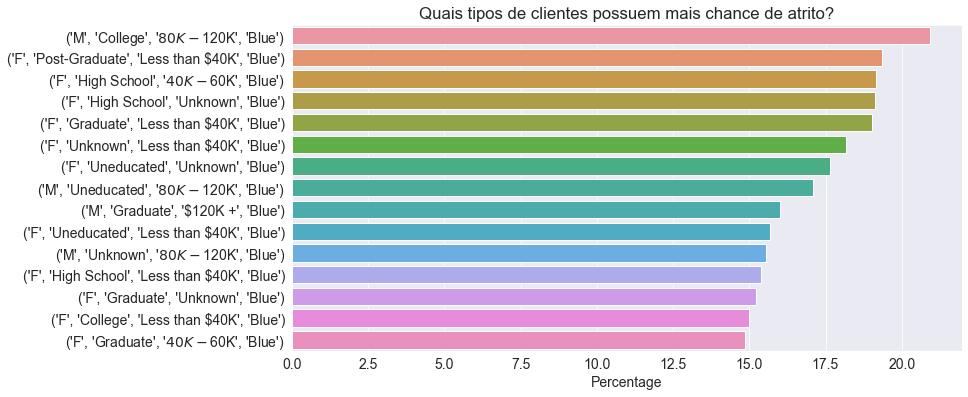

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(x = top_percentage, y = top_types)
plt.title('Quais tipos de clientes possuem mais chance de atrito?')
plt.xlabel('Percentage');

Nota-se que clientes do sexo feminino que fazem parte da menor categoria de renda e clientes do sexo masculino com uma maior renda anual possuem um maior teor de atrição. Talvez a criação de políticas especiais para esses grupos de clientes possa resultar numa redução da atrição de clientes.

## 4. Modelagem e Avaliação do Modelo

Finalmente podemos passar para a etapa de construção do modelo, mas, antes de tudo, vamos separar os nossos conjuntos de treino e teste. Começaremos criando um novo dataset sem a coluna do identificador dos clientes:

In [24]:
train_test_df = churners_df.drop(['CLIENTNUM'], axis=1)
train_test_df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Agora, iremos mapear as variáveis categóricas que possuem uma ordenação natural para números inteiros ordenados na ordem ideal e transformar as variáveis categóricas sem ordem em novas variáveis binárias para cada categoria:

In [25]:
# Convertendo as variáveis categóricas ordinais para inteiros correspondentes
train_test_df['Gender'] = train_test_df['Gender'].map({'M': 0, 'F': 1})
train_test_df['Education_Level'] = train_test_df['Education_Level'].map({'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6})
train_test_df['Income_Category'] = train_test_df['Income_Category'].map({'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5})
train_test_df['Card_Category'] = train_test_df['Card_Category'].map({'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3})

In [26]:
# Criando novas variáveis binárias para cada categoria
dummies_marital = pd.get_dummies(train_test_df['Marital_Status']).drop('Unknown', axis=1)
train_test_df = pd.concat([train_test_df.drop('Marital_Status', axis=1), dummies_marital], axis=1)
train_test_df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Divorced,Married,Single
0,Existing Customer,45,0,3,2,3,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1,0
1,Existing Customer,49,1,5,4,1,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0,1
2,Existing Customer,51,0,3,4,4,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1,0
3,Existing Customer,40,1,4,2,1,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0
4,Existing Customer,40,0,3,1,3,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1,0


Podemos então separar as variáveis independentes e dependentes, além de dividir os conjuntos em treino e teste. Como não temos uma grande quantidade de dados, iremos dividir 75% do conjunto para treino e 25% do conjunto para teste.

In [27]:
X = train_test_df.drop(['Attrition_Flag'], axis = 1)
y = train_test_df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=589)

In [28]:
print('X_train shape:', X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (7595, 21)
X_test shape: (2532, 21)
y_train shape: (7595,)
y_test shape: (2532,)


Com nossos conjuntos de treino e teste definidos, agora precisamos definir qual algoritmo iremos utilizar. Há inúmeras possibilidades de algoritmos, não existindo somente um correto, o que vai definir essa escolha será o contexto do problema, as características dos dados, requisitos como explicabilidade ou velocidade, etc. Como nosso projeto se trata de um problema de classificação, iremos utilizar o algoritmo de Random Forest. 

O algoritmo de Random Forest utiliza a técnica de 'bagging', que consiste em treinar vários modelos (árvores de decisão, no caso do Random Forest) com subconjuntos aleatórios dos dados e depois usar a média das previsões dos modelos para fazer a previsão final. Devido a essa característica de utilizar um subconjunto dos dados para cada árvore, o modelo se torna menos dependente de determinados conjuntos dos dados e generaliza melhor, assim evitando overfitting.

![Random Forest](https://i.imgur.com/k2AKRjN.png)

Como falamos anteriormente, o nosso conjunto de dados é desbalanceado em relação ao nosso target, portanto, precisaremos balanceá-los. Os principais métodos de balanceamento são:

- **Class weight:** Consiste em atribuir pesos inversamente proporcionais às frequências das classes durante o treino, de modo que erros na classe minoritária sejam mais punidos.
- **Undersampling:** Consiste em remover dados da classe majoritária do conjunto de treino para reduzir a desigualdade.
- **Oversampling:** Consiste em criar novas observações da classe minoritária a partir das informações da mesma.

No nosso caso, iremos utilizar a abordagem dos pesos. Vamos então criar agora um modelo simples de Random Forest e treiná-lo:

In [29]:
clf = RandomForestClassifier(n_estimators = 600, 
                             max_depth = 20, 
                             max_leaf_nodes = 20, 
                             class_weight = 'balanced', 
                             random_state = 485)

In [30]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, max_leaf_nodes=20,
                       n_estimators=600, random_state=485)

Iremos agora avaliar a performance do nosso modelo utilizando os dados de treino. Como há um grande desbalanceamento nos dados, utilizar a métrica de acurácia poderia levar a uma análise enganosa, já que, por exemplo, se em um conjunto a classe majoritária representar 95% das observações e o modelo classificar tudo como sendo da classe majoritária, ele conseguiria uma acurácia de 95% mesmo falhando em reconhecer a classe minoritária.

Sendo assim, iremos utilizar métricas que nos permitam identificar se o modelo está performando bem na classificação tanto da classe minoritária quanto da classe majoritária, são elas:

- **Matriz de confusão:** Consiste em uma tabela em que as colunas indicam as previsões e as linhas indicam as classes verdadeiras, através dela é possível identificarmos quantas observações da classe X foram previstas como da classe Y.

![Confusion Matrix](https://i.imgur.com/8KCwvQU.png)

- **Precisão:** Indica quantas das observações classificadas como positivas são de fato positivas. É útil quando a existência de falsos positivos é prejudicial para o problema.

$$\large Precisão = \frac{TP}{TP + FP}$$

- **Recall:** Indica quantas das observações positivas foram de fato classificadas como positivas. É útil quando a existência de falsos negativos é prejudicial para o problema.

$$\large Recall = \frac{TP}{TP + FN}$$

- **F1-score:** Combina a precisão e o recall, sendo calculada como a média harmônica de ambos. Quanto mais próximo de 1, melhor a performance do modelo.

$$\large F1\mbox{-}score = \frac{2 \times Precisão \times Recall}{Precisão + Recall}$$



                   precision    recall  f1-score   support

Attrited Customer       0.68      0.90      0.77       407
Existing Customer       0.98      0.92      0.95      2125

         accuracy                           0.92      2532
        macro avg       0.83      0.91      0.86      2532
     weighted avg       0.93      0.92      0.92      2532



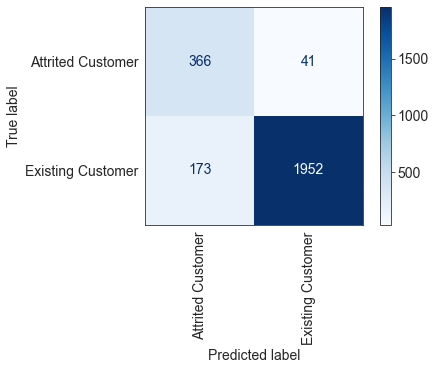

In [31]:
sns.set_style('white')
print(classification_report(y_test, clf.predict(X_test)))
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', xticks_rotation = 'vertical');

Nosso modelo está se saindo muito bem na classificação da situação do cliente, apresentando um recall de 0.9 para clientes atritados e de 0.92 para clientes existentes, o que é ótimo, já que o nosso foco é evitar que clientes com chance de atrito realizem o ato e não desperdiçar recursos com clientes que não possuem alta probabilidade de atritar. 

Por fim, um conceito que é importante nos atentarmos em problemas de classificação é o de `limiar` ou `threshold`. O limiar nada mais é do que um valor de corte, onde uma observação com score acima dele é classificada como positiva e uma com score abaixo é classificada como negativa. Por padrão, o método predict do Random Forest possui o limiar de 0.5. 

Para entendermos melhor como funciona o limiar, vamos visualizar a distribuição dos scores de cada classe no conjunto de treino com algum limiar arbitrário:

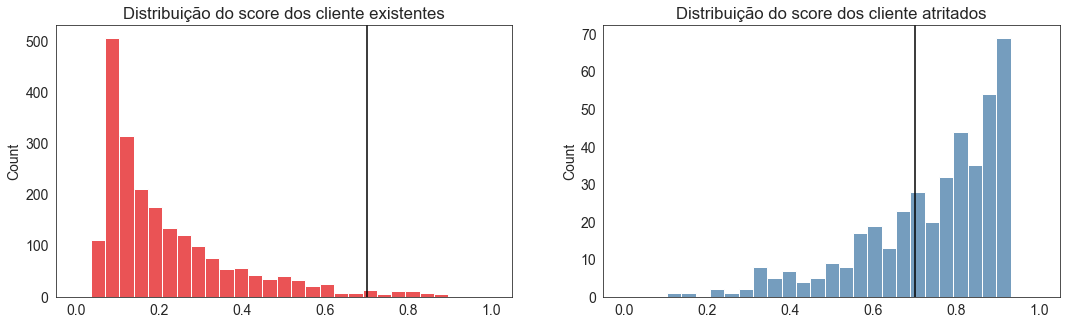

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(x = clf.predict_proba(X_test[y_test == 'Existing Customer'])[:, 0], bins=np.linspace(0, 1, 30), ax=ax[0])
ax[0].set_title('Distribuição do score dos cliente existentes')
ax[0].axvline(0.7, color='black')

sns.histplot(x = clf.predict_proba(X_test[y_test == 'Attrited Customer'])[:, 0], bins=np.linspace(0, 1, 30), ax=ax[1], color='#477ca8')
ax[1].set_title('Distribuição do score dos cliente atritados')
ax[1].axvline(0.7, color='black')

plt.tight_layout;

Como é possível perceber, quanto maior o limiar, menor é o total de falsos positivos e menor é o total de verdadeiros positivos. Já ao diminuirmos o limiar, aumentamos a total de verdadeiros positivos e o total de falsos positivos. Desse modo, a definição do limiar impactará no desempenho do nosso modelo.

Uma das formas de podermos visualizarmos esse trade-off no desempenho do nosso modelo para diferentes limiares é através da curva ROC.  A curva ROC (Receiver Operating Characteristic) é uma representação gráfica que ilustra o desempenho de um classificador binário à medida que o seu limiar varia. O eixo x indica a taxa de falsos positivos, ou seja, a taxa de quantas das observações negativas foram classificadas como positivas. Já o eixo y indica a taxa de verdadeiros positivos, também conhecida como recall.

![Curva ROC](https://upload.wikimedia.org/wikipedia/commons/3/3d/Curva_ROC.svg)

$$\large Taxa \enspace de \enspace falsos \enspace positivos = \frac{FP}{TN + FP}$$

Idealmente, desejamos que a taxa de verdadeiros positivos seja o mais próximo possível de 1, enquanto a taxa de falsos positivos seja o mais próximo possível de 0. Além de que a curva ROC esteja acima da diagonal, que representa a performance de um classificador aleatório.

Além disso, é possível resumirmos o desempenho do modelo numa medida através da AUC (Area Under the Curver) da ROC, que consiste em uma métrica que varia de 0 a 1 e corresponde a área embaixo da curva ROC, onde quanto mais próximo de 1, melhor.

Vamos agora visualizar a curva ROC do nosso modelo:

AUC Score: 0.9687931782049428


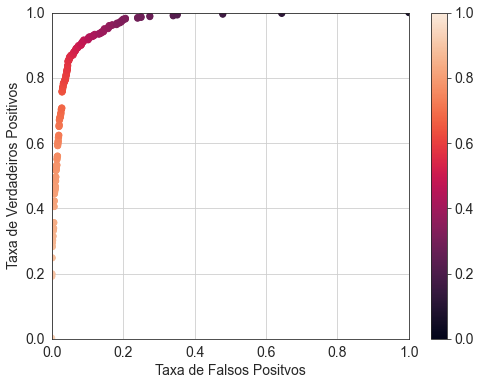

In [33]:
fpr, tpr, ths = roc_curve(y_test, clf.predict_proba(X_test)[:, 0], pos_label = 'Attrited Customer')

plt.figure(figsize=(8, 6))
plt.scatter(fpr, tpr, c=ths, vmin=0, vmax=1)
plt.xlabel('Taxa de Falsos Positvos')
plt.ylabel('Taxa de Verdadeiros Positivos')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar();
plt.grid()

print('AUC Score:', roc_auc_score(y_test.map({'Existing Customer': 0, 'Attrited Customer': 1}), clf.predict_proba(X_test)[:, 0]));

Outra forma de selecionarmos o limiar ideal é avaliarmos o desempenho com métricas específicas para o problema, como o lucro ou prejuízo total. Por exemplo, suponha que um cliente que não atrite resulte num lucro de 3, que desperdiçarmos os esforços com um cliente que não irá atritar resulte num prejuízo de 2 e que não conseguirmos evitar o atrito resulte num prejuízo de 6 para o banco. Podemos então definir uma função que calcule o lucro ou prejuízo total para as observações do conjunto dependendo do limiar:

In [34]:
def profit_cost(x, y, threshold, tp_profit=3, tn_profit=3, fp_cost=-2, fn_cost=-6):
    concat_df = pd.concat([X_test, y_test], axis=1)
    concat_df['pred'] = (clf.predict_proba(X_test)[:, 0] > threshold).astype(int)
    concat_df['Attrition_Flag'] = concat_df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
    
    concat_df.loc[(concat_df.Attrition_Flag == 0) & (concat_df.pred == 0), 'total'] = tn_profit
    concat_df.loc[(concat_df.Attrition_Flag == 1) & (concat_df.pred == 0), 'total'] = fn_cost
    concat_df.loc[(concat_df.Attrition_Flag == 1) & (concat_df.pred == 1), 'total'] = tp_profit
    concat_df.loc[(concat_df.Attrition_Flag == 0) & (concat_df.pred == 1), 'total'] = fp_cost
    
    return concat_df.total.sum()

E então podemos visualizar como o lucro ou prejuízo varia com a mudança do limiar e selecionarmos o limiar que corresponde ao maior lucro.

Limiar que maximiza o lucro: 0.5714285714285714


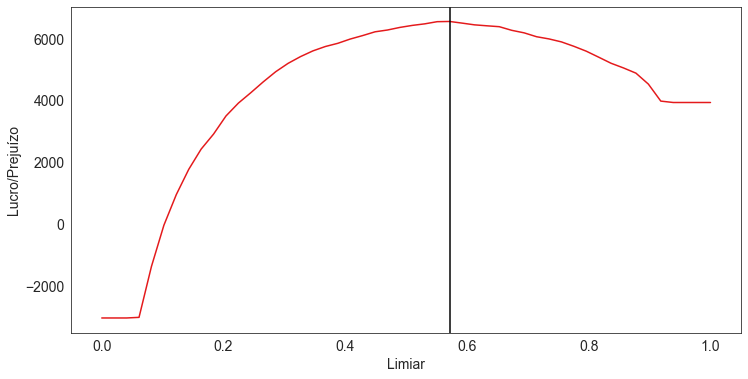

In [35]:
profits = []
thresholds = np.linspace(0, 1, 50)
for ths in thresholds:
    profits.append(profit_cost(X_test, y_test, ths))
    
argmax = np.argmax(profits)
plt.figure(figsize=(12, 6))
plt.plot(thresholds, profits)
plt.xlabel('Limiar')
plt.ylabel('Lucro/Prejuízo')
plt.axvline(thresholds[argmax], color='black', label='Limiar')

print('Limiar que maximiza o lucro:', thresholds[argmax]);

Por fim, podemos salvar o modelo para não precisarmos retreiná-lo sempre que formos utilizá-lo:

In [36]:
pickle.dump(clf, open('model.pkl', 'wb'))

## 5. Conclusão

Poderíamos ainda analisar o modelo para ajudar os parâmetros do modelo a fim de aperfeiçoar seu desempenho ou comparar sua performance com outros algoritmos de classificação, mas, como esse não é o objetivo do projeto, podemos parar por aqui. Obrigado pela leitura e espero que esse projeto lhe tenha sido útil. Até mais!

## 6. Referências

- **Dataset:** https://www.kaggle.com/sakshigoyal7/credit-card-customers
- **Crédito Rotativo:** https://blog.nubank.com.br/o-que-e-credito-rotativo/
- **Quarter over Quarter:** https://www.investopedia.com/terms/q/quarter-over-quarter.asp
- **Random Forest:** https://scikit-learn.org/stable/modules/ensemble.html#forest
- **Curva ROC:** https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics